## Evaluating the Homer TF-peak scoring method

Homer `annotatePeaks.pl` attempts to find TF motif binding sites in a provided set of peak locations. The output of `annotatePeaks.pl` is a file for each TF with information about its binding potential to the peaks in your dataset. The columns are:

- PeakID
- Chromosome
- Peak start position
- Peak end position
- Strand
- Peak Score
- FDR/Peak Focus Ratio/Region Size
- Annotation (i.e. Exon, Intron, ...)
- Detailed Annotation (Exon, Intron etc. + CpG Islands, repeats, etc.)
- Distance to nearest RefSeq TSS
- Nearest TSS: Native ID of annotation file
- Nearest TSS: Entrez Gene ID
- Nearest TSS: Unigene ID
- Nearest TSS: RefSeq ID
- Nearest TSS: Ensembl ID
- Nearest TSS: Gene Symbol
- Nearest TSS: Gene Aliases
- Nearest TSS: Gene description
- Additional columns depend on options selected when running the program.

To test the accuracy of Homer, we can have it predict the TF binding sites for ChIP-seq TF-DNA binding interactions. We can compare the TF-DNA Homer predictions to the known binding interactions to determine how well Homer identifies correct TF-DNA binding partners.

So far, we have been evaluating our results against the mESC ground truth from the BEELINE paper. The paper does not provide the TF-peak ChIP-seq file, but rather the direct TF-TG mapping. The paper states that the ChIP-seq dataset was downloaded from ChIP-Atlas, so we are using the **mm10 embryo ChIP: TFs and others** dataset from ChIP-Atlas.

In [ ]:
!hostnamectl

   Static hostname: psh01com1hcom34
         Icon name: computer-server
           Chassis: server
        Machine ID: 4232d1115a5548e982021ba5a27af5c3
           Boot ID: 7722405a22e04dd3b701e19ac5a96705
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [3]:
import os
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
output_dir = os.path.join(base_dir, "output/chipseq_homer")
tmp_dir = os.path.join(output_dir, "tmp")

os.makedirs(ground_truth_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

### ChIP-Atlas data

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

The first step here is to extract the relevant information from the ChIP-Atlas dataset to create a TF-peak ground truth DataFrame and a `homer_peaks.txt` DataFrame.

In [3]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

In [5]:
chip_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_bed = pybedtools.BedTool(chip_bed_file)
chip_bed_df = chip_bed.to_dataframe()
chip_bed_nohead = chip_bed_df.iloc[1:, :].dropna()

chip_bed_nohead["gene_id"] = chip_bed_nohead["name"].apply(extract_gene_name)
chip_bed_cleaned = chip_bed_nohead[["chrom", "start", "end", "gene_id"]]

# Set the peak_id as the formatted peak location
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

chip_tf_to_peak = chip_bed_cleaned[["gene_id", "peak_id"]]
chip_tf_to_peak

/tmp/ipykernel_442203/3085763299.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)


,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677
...,...,...
7624387,Rest,chrY_JH584303_random:135985-136047
7624388,Rest,chrY_JH584303_random:135985-136048
7624389,Rest,chrY_JH584303_random:135986-136045
7624390,Rest,chrY_JH584303_random:135989-136043


Now that we have the ChIP-Atlas peaks in the format that we want, we can save it to the ground truth directory for later

In [5]:
chip_bed_cleaned.to_csv(os.path.join(output_dir, "chipatlas_peaks.csv"), header=True, index=False)
chip_tf_to_peak.to_csv(os.path.join(ground_truth_dir, "chipatlas_mESC.csv"), header=True, index=False)

### Creating the Homer peaks file

Next, we need to format the peaks to follow the requirements for the Homer peaks file.

> HOMER peak files should have at minimum 5 columns (separated by TABs, additional columns will be ignored:
> - Column1: Unique Peak ID
> - Column2: chromosome
> - Column3: starting position
> - Column4: ending position
> - Column5: Strand (+/- or 0/1, where 0="+", 1="-")

In [4]:
chip_bed_cleaned = pd.read_csv(os.path.join(ground_truth_dir, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=False)
chip_tf_to_peak = chip_bed_cleaned[["source_id", "peak_id"]].rename(columns={"source_id":"gene_id"})
chip_tf_to_peak

,gene_id,peak_id
0,SMAD4,chr1:3003564-3003922
1,CTCF,chr1:3012605-3012815
2,CTCF,chr1:3012635-3012824
3,EPITOPE,chr1:3031387-3031654
4,SMAD4,chr1:3031454-3031677
...,...,...
7734461,REST,chrY_JH584303_random:135985-136047
7734462,REST,chrY_JH584303_random:135985-136048
7734463,REST,chrY_JH584303_random:135986-136045
7734464,REST,chrY_JH584303_random:135989-136043


In [ ]:
# Format the DataFrame to follow the requirements for the Homer peaks file (used for both Homer and Homer Binding)
homer_peaks = chip_bed_cleaned[["peak_id", "chrom", "start", "end"]]
homer_peaks = homer_peaks.rename(columns={"peak_id":"PeakID", "chrom":"chr"})
homer_peaks["strand"] = ["."] * len(homer_peaks)
homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)
homer_peaks

,PeakID,chr,start,end,strand
1,chr1:3003564-3003922,chr1,3003564,3003922,.
2,chr1:3012605-3012815,chr1,3012605,3012815,.
3,chr1:3012635-3012824,chr1,3012635,3012824,.
4,chr1:3031387-3031654,chr1,3031387,3031654,.
5,chr1:3031454-3031677,chr1,3031454,3031677,.
...,...,...,...,...,...
7624387,chrY_JH584303_random:135985-136047,chrY_JH584303_random,135985,136047,.
7624388,chrY_JH584303_random:135985-136048,chrY_JH584303_random,135985,136048,.
7624389,chrY_JH584303_random:135986-136045,chrY_JH584303_random,135986,136045,.
7624390,chrY_JH584303_random:135989-136043,chrY_JH584303_random,135989,136043,.


This is a huge file - we dont need to test the method using all of them. We will take a sample to run the scoring on.

In [88]:
homer_peaks_sample = homer_peaks.sample(frac=0.15)
homer_peaks_sample.shape[0]

258219

If we save the ChIP-seq peaks as `homer_peaks.txt` to the `tmp` directory of the output folder, then they will be used to calculate the Homer Binding and Homer scores

In [8]:
homer_peak_path = os.path.join(tmp_dir, "homer_peaks.txt")
homer_peaks.to_csv(homer_peak_path, sep="\t", header=False, index=False)

### Running Homer

Now that we have created the ground truth TF-peak and `homer_peaks.txt` files, we can run Homer on the ChIP-seq peaks

In [11]:
!sbatch /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/testing_scripts/run_homer_on_chipseq.sh

Submitted batch job 3388167


This bash script runs three processes:
1. Homer `findMotifsGenome.pl`, which identifies enriched TF binding motifs in the genome.
2. Homer `annotatePeaks.pl`, which matches TFs to a given set of peaks and provides mapping to the closet gene's TSS.
3. `homer_tf_peak_motifs.py`, which uses the output of `annotatePeaks.pl` to calculate a binding score between each TF and peak. The TF binding score for a peak is calculated by taking the number of TF binding motifs for the peak / total TF motifs across all peaks.

Once the bash script has finished, we can read in the output of `homer_tf_peak_motifs.py`, `homer_tf_to_peak.parquet`

### Comparing Homer TF-peak predictions vs ChIP-seq

In [5]:
homer_results = pd.read_parquet(os.path.join(output_dir, "homer_tf_to_peak.parquet"), engine="pyarrow")
homer_results = homer_results.reset_index(drop=True)
homer_results

,peak_id,source_id,homer_binding_score
0,chrX:105069965-105070449,AMYB,4.867642e-07
1,chr5:59956009-59956370,AMYB,4.867642e-07
2,chr3:99913459-99914013,AMYB,4.867642e-07
3,chr11:87126722-87127805,AMYB,4.867642e-07
4,chr5:148073521-148073748,AMYB,4.867642e-07
...,...,...,...
286963212,chr5:97898104-97898163,GATA3,2.426051e-05
286963213,chr4:42945991-42946279,GATA3,3.032564e-06
286963214,chr18:61975675-61975856,GATA3,3.032564e-06
286963215,chr10:80433744-80434239,GATA3,3.032564e-06


In [6]:
# Load in the TF-peak-nearest gene TSS distance ChIP-Atlas edge file
chip_atlas_edges_full = pd.read_csv(os.path.join(ground_truth_dir, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=None)
chip_atlas_edges_full = chip_atlas_edges_full[["source_id", "peak_id", "target_id", "distance"]]

We will read in the TF-peak-nearest gene TSS distance file for ChIP-Atlas and merge the edges with Homer's TF-peak scores. We merge on the peaks so that  we get a dataframe with Homer's prediction for the TF-peak edge, the ChIP-Atlas TF-peak edge, the nearest gene TSS to the peak, and the distance from the peak to the TSS.

Assuming the ChIP-Atlas edges are correct, we can classify the Homer results as True or False based on whether they match the ChIP-Atlas prediction. If Homer accurately predicts TF-peak binding interactions, then we would expect to see higher scores for True interactions compared to False interactions.

In [6]:
chipseq_gene_tss_homer_df = pd.merge(homer_results, chip_atlas_edges_full, on="peak_id", how="inner")
chipseq_gene_tss_homer_df.head()

,peak_id,source_id_x,homer_binding_score,source_id_y,target_id,distance
0,chrX:105069965-105070449,AMYB,4.867642e-07,Pbx1,5530601h04rik,0
1,chr5:59956009-59956370,AMYB,4.867642e-07,Epitope,4933402j10rik,29632
2,chr3:99913459-99914013,AMYB,4.867642e-07,Hoxa11,Spag17,28043
3,chr11:87126722-87127805,AMYB,4.867642e-07,Smarca4,Trim37,0
4,chr5:148073521-148073748,AMYB,4.867642e-07,Ctcf,Mtus2,116202


In [7]:
chipseq_gene_tss_homer_df["source_id_y"] = chipseq_gene_tss_homer_df["source_id_y"].str.upper()

In [8]:
tf_peak_edges_in_chipatlas = chipseq_gene_tss_homer_df[chipseq_gene_tss_homer_df["source_id_x"] == chipseq_gene_tss_homer_df["source_id_y"]]
tf_peak_edges_not_in_chipatlas = chipseq_gene_tss_homer_df[chipseq_gene_tss_homer_df["source_id_x"] != chipseq_gene_tss_homer_df["source_id_y"]]

In [12]:
true_scores = tf_peak_edges_in_chipatlas["homer_binding_score"].rename("Homer Binding Scores for\n Edges in ChIP-Atlas")
false_scores = tf_peak_edges_not_in_chipatlas["homer_binding_score"].rename("Homer Binding Scores for\n Edges Not in ChIP-Atlas")
false_scores_balanced = false_scores.sample(len(true_scores))
true_false_chip_atlas_scores_merged = pd.merge(
    true_scores,
    false_scores_balanced,
    left_index=True,
    right_index=True,
    how="outer"
)

In [21]:
print(len(true_false_chip_atlas_scores_merged["Homer Binding Scores for\n Edges Not in ChIP-Atlas"].dropna()))
print(len(true_false_chip_atlas_scores_merged["Homer Binding Scores for\n Edges in ChIP-Atlas"].dropna()))

2400952
2400952


In [18]:
true_false_sample = true_false_chip_atlas_scores_merged.sample(10000)

In [22]:
print(len(true_false_sample["Homer Binding Scores for\n Edges Not in ChIP-Atlas"].dropna()))
print(len(true_false_sample["Homer Binding Scores for\n Edges in ChIP-Atlas"].dropna()))

5002
4998


Text(0.5, 1.0, 'Homer Binding Scores for ChIP-Atlas TFs and peaks')

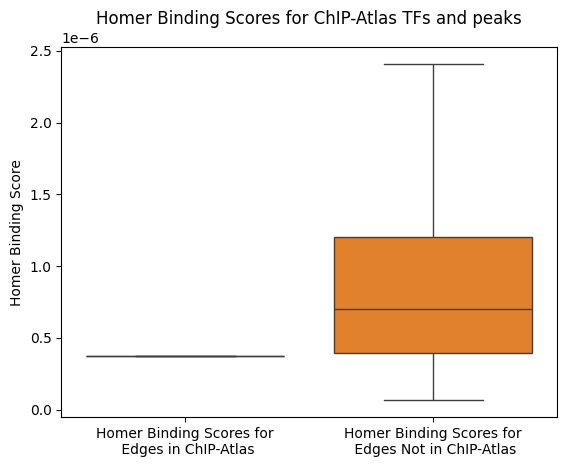

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.Figure()
a = sns.boxplot(data=true_false_sample, showfliers=False)
a.set_ylabel("Homer Binding Score")
a.set_title("Homer Binding Scores for ChIP-Atlas TFs and peaks")

In [36]:
import importlib

importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

In [26]:
import dev.notebooks.plotting as dev_plots

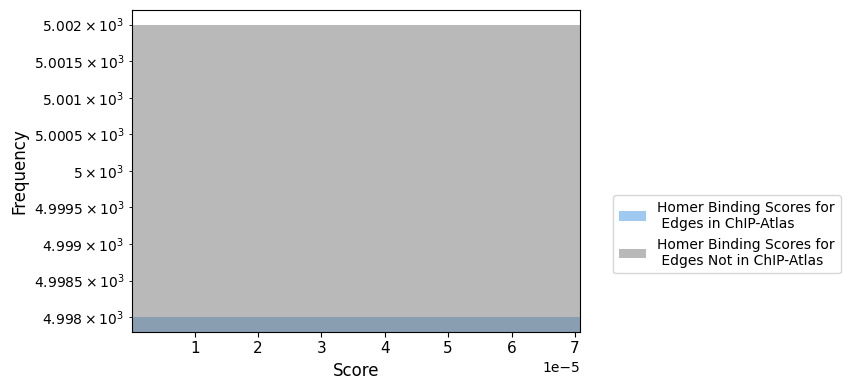

In [39]:
fig = dev_plots.plot_true_false_distribution(
    true_series=true_false_sample["Homer Binding Scores for\n Edges in ChIP-Atlas"],
    false_series=true_false_sample["Homer Binding Scores for\n Edges Not in ChIP-Atlas"],
    log=True
)
fig.show()

In [31]:
true_false_sample["Homer Binding Scores for\n Edges in ChIP-Atlas"].name

AttributeError: 'str' object has no attribute 'str'

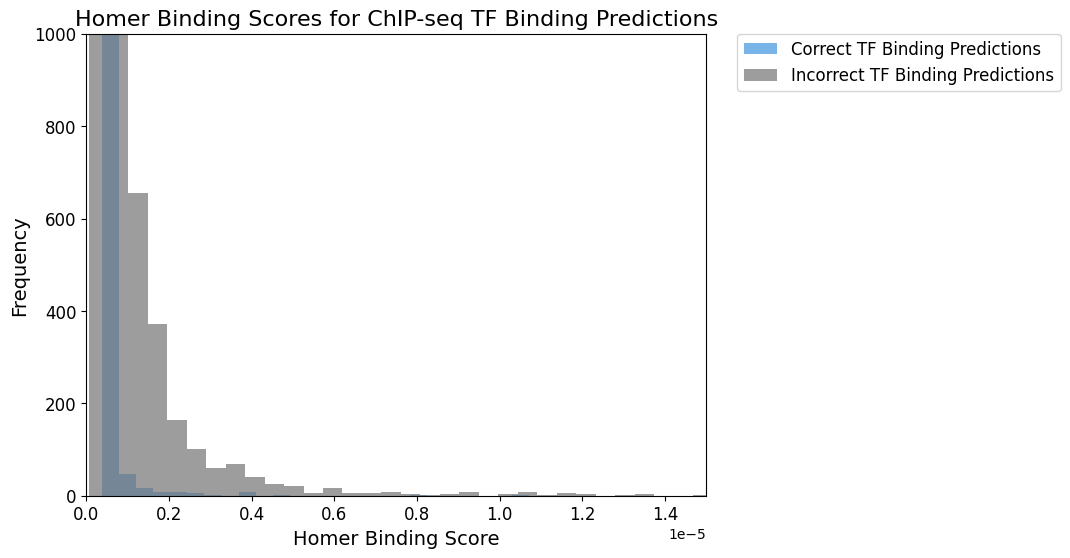

In [ ]:
import numpy as np
plt.figure(figsize=(8,6))
plt.hist(
    np.log1p(true_false_sample["Homer Binding Scores for\n Edges in ChIP-Atlas"]),
    bins=25,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    np.log1p(true_false_sample["Homer Binding Scores for\n Edges Not in ChIP-Atlas"]),
    bins=150,
    alpha=0.7,
    color='#747474',
    label="Incorrect TF Binding Predictions"
)
plt.title("Homer Binding Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Homer Binding Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.xlim(0,1.5e-5)
# plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_histogram.png", dpi=200)

plt.show()

In [54]:
import numpy as np
def find_peak_length(df: pd.DataFrame, peak_col_name: str = "peak_id"):
    df = df.copy()
    
    peak_col = df[peak_col_name]
    
    peak_col_split = peak_col.str.extract(r'(chr[\w]+):([0-9]+)-([0-9]+)').dropna()
    df["peak_length"] = np.abs(peak_col_split[2].astype(int) - peak_col_split[1].astype(int))
    
    return df

peak_len_df = find_peak_length(chipseq_gene_tss_homer_df.sample(50000).drop_duplicates())
peak_len_df.head(1000)

,peak_id,source_id_x,homer_binding_score,source_id_y,target_id,distance,peak_length
281325329,chr8:68839422-68839663,FOXA1,5.131524e-07,NEUROD2,Lpl,40891,241
107584166,chr4:33846200-33846398,Nanog,4.637047e-07,SIX2,Cnr1,77865,198
213162968,chr12:93088096-93088533,ZBTB18,2.959679e-06,TWIST1,4930559c10rik,356290,437
206179363,chrX:162915790-162915934,USF1,1.323329e-06,CTCF,Ctps2,13620,144
77990338,chr13:107675087-107675371,BMAL1,4.084507e-07,CTCF,1700006h21rik,12025,284
...,...,...,...,...,...,...,...
81475807,chr11:106980508-106980765,Mef2b,1.123177e-06,CTCF,Kpna2,18760,257
89778197,chr7:44246115-44246377,MyoG,9.588252e-07,SMARCA4,2410002f23rik,344,262
250706780,chr6:124662544-124662827,EBF1,9.254589e-07,SIX2,Lpcat3,276,283
100319389,chr15:76671474-76671587,NFY,1.023094e-06,PKNOX1,Ppp1r16a,55,113


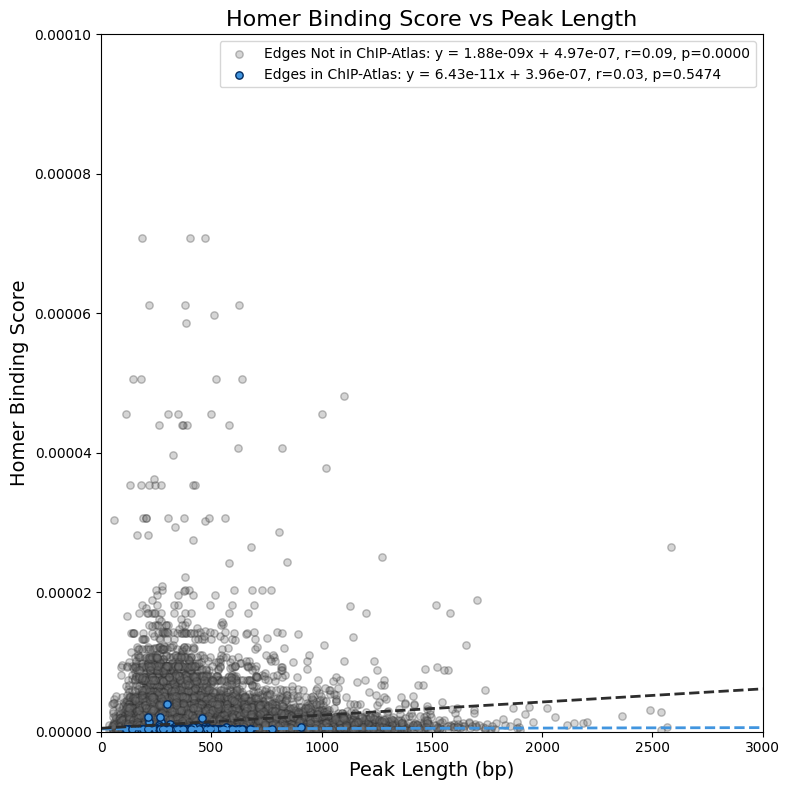

Edges in ChIP-Atlas: y = 6.43e-11x + 3.96e-07, r=0.03, p=0.5474
False Values: Correlation = 0.09, p-value = 0.0000
True Values: Correlation = 0.03, p-value = 0.5474


In [81]:
from scipy.stats import pearsonr, linregress
import numpy as np

pos_peak_len_df = peak_len_df[peak_len_df["homer_binding_score"] > 0]
true_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] == pos_peak_len_df["source_id_y"]]
false_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] != pos_peak_len_df["source_id_y"]]

fig = plt.figure(figsize=(8,8))
false_correlation = pearsonr(false_df["peak_length"], false_df["homer_binding_score"])
true_correlation = pearsonr(true_df["peak_length"], true_df["homer_binding_score"])

true_slope, true_intercept, true_r, true_p, true_stderr = linregress(true_df["peak_length"], true_df["homer_binding_score"])
true_line = f'Edges in ChIP-Atlas: y = {true_slope:.2e}x + {true_intercept:.2e}, r={true_r:.2f}, p={true_p:.4f}'

false_slope, false_intercept, false_r, false_p, false_stderr = linregress(false_df["peak_length"], false_df["homer_binding_score"])
false_line = f'Edges Not in ChIP-Atlas: y = {false_slope:.2e}x + {false_intercept:.2e}, r={false_r:.2f}, p={false_p:.4f}'

sc_false = plt.scatter(x=false_df["peak_length"], y=false_df["homer_binding_score"], s=28,  c="#747474", edgecolors="#2D2D2D", label=false_line, alpha=0.3, rasterized=True)
sc_true = plt.scatter(x=true_df["peak_length"], y=true_df["homer_binding_score"], s=28, edgecolors="#032b5f", label=true_line, c="#4195df",  rasterized=True)

max_x = max(max(true_df["peak_length"]), max(false_df["peak_length"])) * 0.9

plt.plot(np.arange(0, max_x), true_intercept + true_slope * np.arange(0, max_x), c="#4195df", linewidth=2, linestyle="--")
plt.plot(np.arange(0, max_x), false_intercept + false_slope * np.arange(0, max_x), c="#2D2D2D", linewidth=2, linestyle="--")

plt.title("Homer Binding Score vs Peak Length", fontsize=16)
plt.xlabel("Peak Length (bp)", fontsize=14)
plt.ylabel("Homer Binding Score", fontsize=14)
plt.ylim(0, 1e-4)
plt.xlim(0, 3000)
plt.legend()
plt.tight_layout()
plt.show()


print(true_line)
print(f"False Values: Correlation = {false_correlation.statistic:.2f}, p-value = {false_correlation.pvalue:.4f}")
print(f"True Values: Correlation = {true_correlation.statistic:.2f}, p-value = {true_correlation.pvalue:.4f}")

We can use the `chip_tf_to_peak` object that we created from the ChIP-Atlas file to check our work. Since we sampled the ChIP-Atlas peaks before we ran Homer, we need to subset `chip_tf_to_peak` to only contain those peaks.

In [7]:
homer_results["source_id"] = homer_results["source_id"].str.upper()
chip_tf_to_peak["gene_id"] = chip_tf_to_peak["gene_id"].str.upper()

In [8]:
print(f"Number of ChIP-Atlas peaks: {chip_tf_to_peak['peak_id'].nunique()}")
print(f"Number of ChIP-Atlas TFs: {chip_tf_to_peak['gene_id'].nunique()}")

Number of ChIP-Atlas peaks: 7508129
Number of ChIP-Atlas TFs: 131


In [9]:
homer_peak_set = set(homer_results["peak_id"])
homer_gene_set = set(homer_results["source_id"])

print(f"Number of Homer peaks: {len(homer_peak_set)}")
print(f"Number of Homer TFs: {len(homer_gene_set)}")

chip_tf_to_peak_sub = chip_tf_to_peak[
    chip_tf_to_peak["peak_id"].isin(homer_peak_set) &
    chip_tf_to_peak["gene_id"].isin(homer_gene_set)
]
chip_tf_to_peak_sub

Number of Homer peaks: 7432863
Number of Homer TFs: 318


,gene_id,peak_id
0,SMAD4,chr1:3003564-3003922
1,CTCF,chr1:3012605-3012815
2,CTCF,chr1:3012635-3012824
4,SMAD4,chr1:3031454-3031677
9,HAND2,chr1:3042840-3043210
...,...,...
7734371,TCF12,chrY_JH584300_random:1327-1457
7734386,SIX2,chrY_JH584300_random:29200-29402
7734391,CTCF,chrY_JH584300_random:125580-125924
7734451,ISL1,chrY_JH584303_random:27542-27608


In [20]:
print(f"Number of shared peaks: {chip_tf_to_peak_sub['peak_id'].nunique()}")
print(f"Number of shared TFs: {chip_tf_to_peak_sub['gene_id'].nunique()}")

Number of shared peaks: 235613
Number of shared TFs: 50


We then combine the TF-peak mapping from ChIP-Atlas with the TF-peak mapping from the Homer score by merging the two DataFrames on `peak_id`.

In [10]:
merged_df = pd.merge(chip_tf_to_peak_sub, homer_results, on="peak_id", how="inner")
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "homer_gene"})
merged_df = merged_df[["chip_gene", "homer_gene", "peak_id", "homer_binding_score"]]
merged_df

,chip_gene,homer_gene,peak_id,homer_binding_score
0,SMAD4,GLIS3,chr1:3003564-3003922,8.127062e-07
1,SMAD4,HIC1,chr1:3003564-3003922,2.672861e-07
2,SMAD4,MNT,chr1:3003564-3003922,5.847772e-07
3,SMAD4,BMAL1,chr1:3003564-3003922,4.084507e-07
4,SMAD4,MAX,chr1:3003564-3003922,6.490384e-07
...,...,...,...,...
190297930,SMAD4,ETV1,chrY_JH584303_random:32038-32409,4.795795e-07
190297931,SMAD4,ELF4,chrY_JH584303_random:32038-32409,7.011379e-07
190297932,SMAD4,ERRA,chrY_JH584303_random:32038-32409,3.108876e-07
190297933,SMAD4,FOXD3,chrY_JH584303_random:32038-32409,8.902500e-07


In [11]:
merged_df.to_csv(os.path.join(output_dir, "chipseq_homer_merged.csv"), header=True, index=False)

We can extract the correct and incorrect predictions to see how the Homer binding scores vary between them.

In [12]:
correct_predictions = merged_df[merged_df["chip_gene"] == merged_df["homer_gene"]]
incorrect_predictions = merged_df[merged_df["chip_gene"] != merged_df["homer_gene"]]

print(f"Num correct predictions: {len(correct_predictions)}")
print(f"Num incorrect predictions: {len(incorrect_predictions)}")

print(f"Num unique correct TFs: {correct_predictions['chip_gene'].nunique()}")
print(f"Num unique incorrect TFs: {incorrect_predictions['chip_gene'].nunique()}")

Num correct predictions: 3143066
Num incorrect predictions: 187154869
Num unique correct TFs: 52
Num unique incorrect TFs: 52


In [35]:
correct_predictions

,chip_gene,homer_gene,peak_id,homer_binding_score,chip_gene_norm,homer_gene_norm
59,SIX2,SIX2,chr1:3117059-3117236,0.212370,SIX2,SIX2
88,SIX2,SIX2,chr1:3372710-3372882,0.212370,SIX2,SIX2
126,SIX2,SIX2,chr1:3400044-3400224,0.212370,SIX2,SIX2
306,HOXA13,HOXA13,chr1:3495185-3495539,0.443424,HOXA13,HOXA13
432,SMAD4,SMAD4,chr1:3584028-3584333,0.253329,SMAD4,SMAD4
...,...,...,...,...,...,...
9233563,CTCF,CTCF,chrY:90839467-90840036,0.071215,CTCF,CTCF
9233638,CTCF,CTCF,chrY:90839518-90840074,0.071215,CTCF,CTCF
9233713,CTCF,CTCF,chrY:90839526-90840044,0.071215,CTCF,CTCF
9233793,CTCF,CTCF,chrY:90839540-90840122,0.071215,CTCF,CTCF


Now that we have split the predictions by correct / incorrect TF to peak binding, we can find the average Homer binding scores when the TF binding is correct vs incorrect

In [13]:
def clean_data(df):
    # Drop columns: 'homer_gene_norm', 'chip_gene_norm'
    df = df.drop(columns=['homer_gene_norm', 'chip_gene_norm'])
    # Performed 1 aggregation grouped on column: 'chip_gene'
    df = df.groupby(['chip_gene']).agg(homer_binding_score_mean=('homer_binding_score', 'mean')).reset_index()
    # Sort by column: 'homer_binding_score_mean' (descending)
    df = df.sort_values(['homer_binding_score_mean'], ascending=[False])
    return df

correct_prediction_scores = clean_data(correct_predictions.copy())
correct_prediction_scores = correct_prediction_scores.rename(columns={
    "homer_binding_score_mean":"Correct TF Binding Prediction"
})
correct_prediction_scores.head()

KeyError: "['homer_gene_norm', 'chip_gene_norm'] not found in axis"

In [ ]:
incorrect_prediction_scores = clean_data(incorrect_predictions.copy())
incorrect_prediction_scores = incorrect_prediction_scores.rename(columns={
    "homer_binding_score_mean":"Incorrect TF Binding Prediction"
})
incorrect_prediction_scores.head()

,chip_gene,Incorrect TF Binding Prediction
10,HNF1B,0.384518
5,FLI1,0.378245
8,FOXL2,0.364243
3,DLX1,0.359907
17,JUND,0.357243


Now that we have extracted the correct and incorrect scores, we will merge them to create a new dataframe containing just the correct and incorrect scores.

In [ ]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, on="chip_gene", how="outer")
pred_df

,chip_gene,Correct TF Binding Prediction,Incorrect TF Binding Prediction
0,ASCL1,0.229014,0.277271
1,CDX2,0.508034,0.294395
2,CTCF,0.077764,0.268498
3,DLX1,0.212263,0.359907
4,EBF1,0.395867,0.302724
5,FLI1,0.353268,0.378245
6,FOSL2,0.827838,0.350731
7,FOXA2,0.400544,0.300222
8,FOXL2,0.245937,0.364243
9,HAND2,0.669219,0.273519


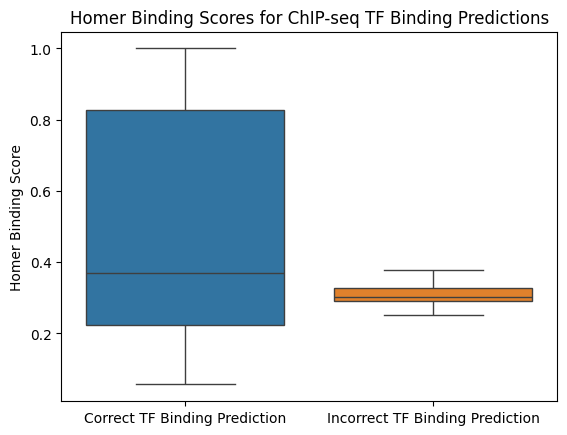

In [ ]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df, showfliers=False)
a.set_ylabel("Homer Binding Score")
a.set_title("Homer Binding Scores for ChIP-seq TF Binding Predictions")
plt.savefig(os.path.join(output_dir, "chipseq_homer_boxplot.png"), dpi=200)

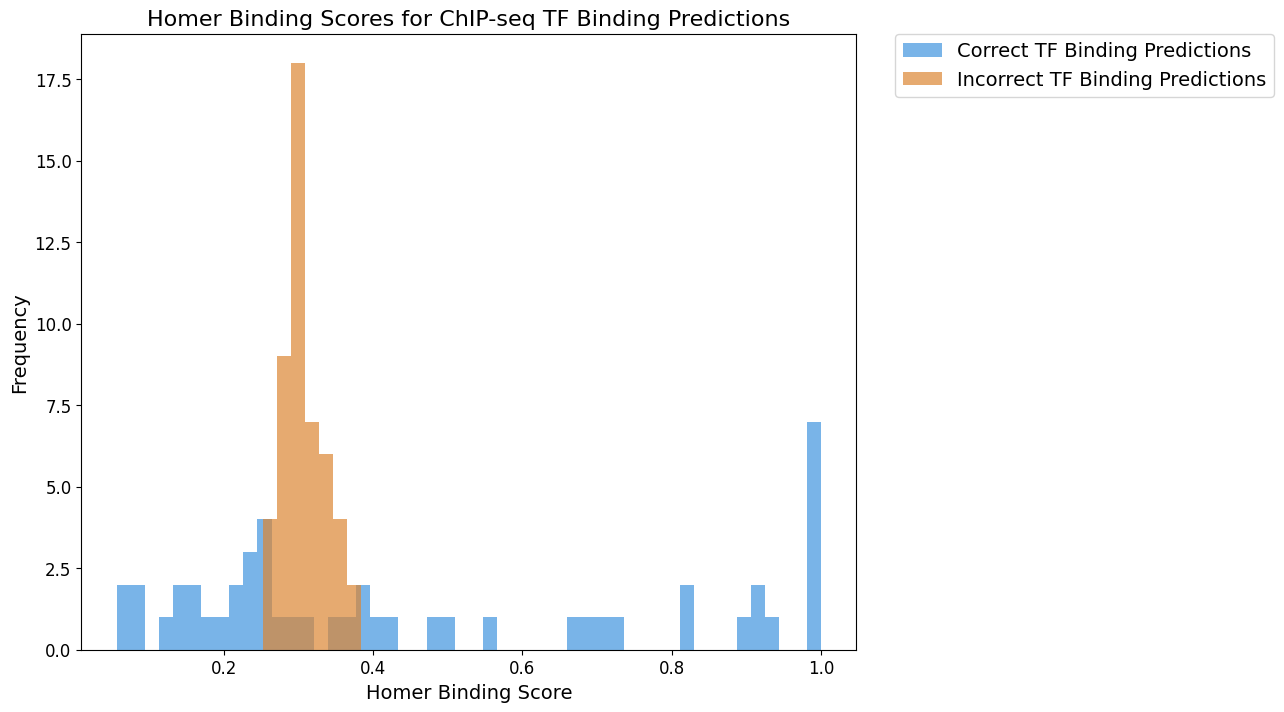

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(
    pred_df["Correct TF Binding Prediction"],
    bins=50,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    pred_df["Incorrect TF Binding Prediction"],
    bins=7,
    alpha=0.7,
    color='#dc8634',
    label="Incorrect TF Binding Predictions"
)
plt.title("Homer Binding Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Homer Binding Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.savefig(os.path.join(output_dir, "chipseq_homer_histogram.png"), dpi=200)

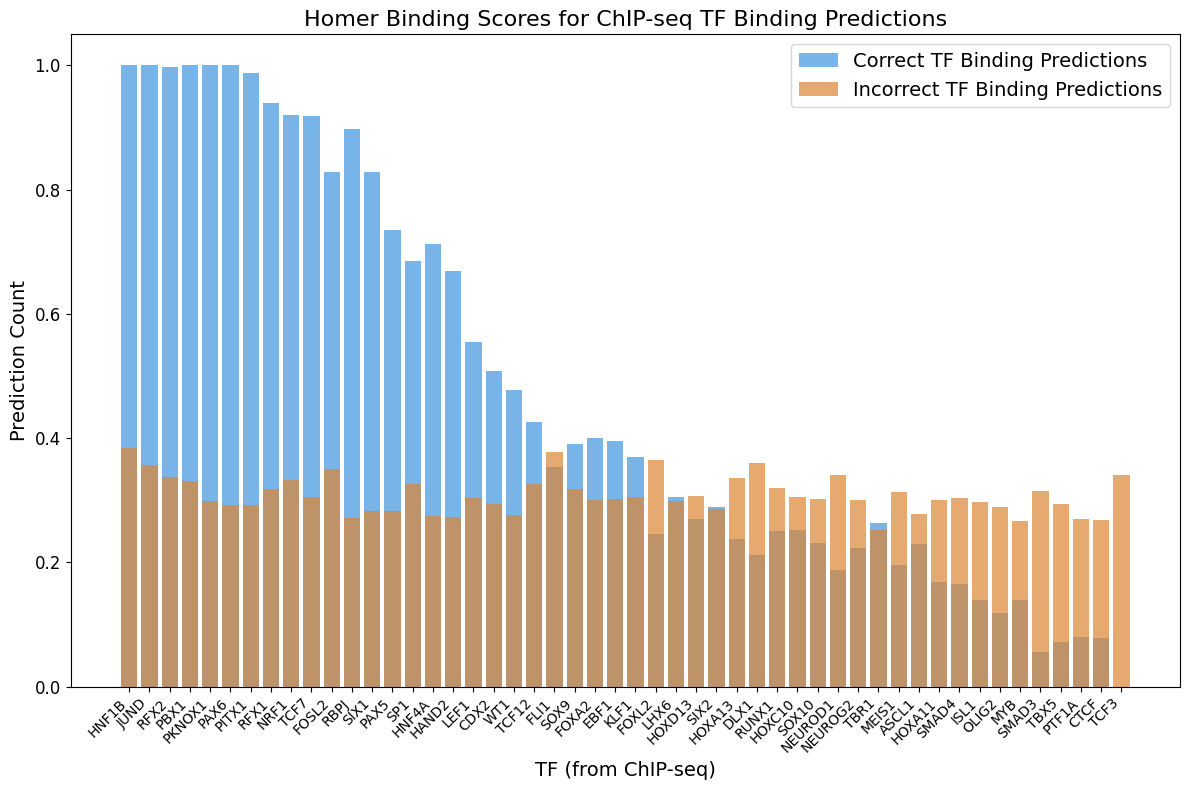

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 1: Sort by total predictions (optional but helps with visual clarity)
pred_df["total"] = pred_df["Correct TF Binding Prediction"] + pred_df["Incorrect TF Binding Prediction"]
pred_df = pred_df.sort_values(by="total", ascending=False)

# Step 2: Setup positions for grouped bars
x = np.arange(len(pred_df))  # numeric x-axis
width = 0.4  # width of each bar

# Step 3: Plot grouped bars
plt.figure(figsize=(12, 8))

plt.bar(
    x,
    pred_df["Correct TF Binding Prediction"],
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)

plt.bar(
    x,
    pred_df["Incorrect TF Binding Prediction"],
    alpha=0.7,
    color='#dc8634',
    label="Incorrect TF Binding Predictions"
)

# Step 4: Format
plt.title("Homer Binding Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("TF (from ChIP-seq)", fontsize=14)
plt.ylabel("Prediction Count", fontsize=14)
plt.xticks(ticks=x, labels=pred_df["chip_gene"], rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, loc="upper right")
plt.tight_layout()

# Step 5: Save
plt.savefig(os.path.join(output_dir, "chipseq_homer_grouped_barplot.png"), dpi=200)
plt.show()
